In [1]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


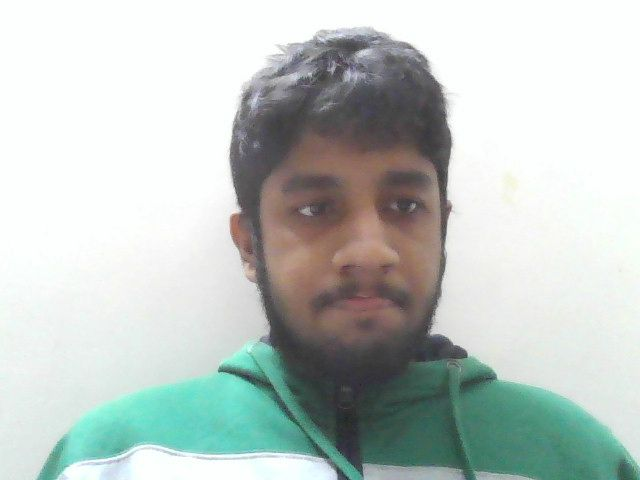

In [2]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [3]:
!pip install mtcnn

     |████████████████████████████████| 2.3 MB 5.2 MB/s 


In [4]:
import mtcnn

In [5]:
from PIL import Image
from numpy import asarray
from mtcnn.mtcnn import MTCNN

In [6]:
def extract_face(filename, required_size=(160, 160)):
	image = Image.open(filename)
	image = image.convert('RGB')
	pixels = asarray(image)
	detector = MTCNN()
	results = detector.detect_faces(pixels)
	x1, y1, width, height = results[0]['box']
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
	face = pixels[y1:y2, x1:x2]
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array

In [7]:
img=extract_face('photo.jpg')

In [8]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [9]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [10]:
import glob
dataset_images=glob.glob("gdrive/My Drive/facial_recog/dataset/*.jpg")

In [11]:
dataset_images

['gdrive/My Drive/facial_recog/dataset/ravi.jpg',
 'gdrive/My Drive/facial_recog/dataset/ashish.jpg',
 'gdrive/My Drive/facial_recog/dataset/vikas.jpg',
 'gdrive/My Drive/facial_recog/dataset/utkarsh.jpg',
 'gdrive/My Drive/facial_recog/dataset/anish.jpg',
 'gdrive/My Drive/facial_recog/dataset/devansh.jpg',
 'gdrive/My Drive/facial_recog/dataset/gurjot.jpg',
 'gdrive/My Drive/facial_recog/dataset/sarthak.jpg',
 'gdrive/My Drive/facial_recog/dataset/aashish.jpg',
 'gdrive/My Drive/facial_recog/dataset/jayant.jpg',
 'gdrive/My Drive/facial_recog/dataset/ayushi.jpg',
 'gdrive/My Drive/facial_recog/dataset/geeta.jpg',
 'gdrive/My Drive/facial_recog/dataset/virendra.jpg',
 'gdrive/My Drive/facial_recog/dataset/darsh.jpg',
 'gdrive/My Drive/facial_recog/dataset/akanksha.jpg',
 'gdrive/My Drive/facial_recog/dataset/prof_karm_veer_arya.jpg',
 'gdrive/My Drive/facial_recog/dataset/priyesh.jpg',
 'gdrive/My Drive/facial_recog/dataset/samyak.jpg',
 'gdrive/My Drive/facial_recog/dataset/aryan.jpg

In [12]:
count=0

In [13]:
labels=[]
for i in dataset_images:
  count=count+1
  i=i.replace('gdrive/My Drive/facial_recog/dataset/','')
  i=i.replace('.jpg','')
  labels.append(i)

In [14]:
image_embeddings=[]
for i in range(count):
  image_embeddings.append(extract_face(dataset_images[i]))

In [15]:
image_embeddings=np.array(image_embeddings)

In [16]:
def normalize(trainX):
  trainX=trainX.astype('float32')
  for i in range (trainX.shape[0]):
    mean=trainX[i].mean()
    std=trainX[i].std()
    trainX[i]=(trainX[i]-mean)/std
  return trainX

In [17]:
image_embeddings=normalize(image_embeddings)

In [18]:
from keras.models import load_model
deep_network = load_model('gdrive/My Drive/facial_recog/facenet_keras.h5')

In [19]:
def getEmbd(trainX):
  embd=deep_network.predict(trainX)
  return embd

In [20]:
image_embeddings=getEmbd(image_embeddings)

In [21]:
image_embeddings

array([[ 0.2281784 , -1.3742216 ,  1.8296683 , ...,  0.1464827 ,
         0.4257652 , -0.34801587],
       [ 0.13735294, -0.36318251, -0.19930181, ...,  0.6317376 ,
         1.2627165 , -0.38628322],
       [ 0.6077678 , -0.7600857 , -0.40012702, ..., -0.8302989 ,
        -0.6323287 ,  0.07325241],
       ...,
       [-0.2952331 , -0.42186293, -0.10613532, ...,  1.4282302 ,
         0.9623217 , -1.0340763 ],
       [-1.1469024 ,  0.88126326, -1.9654095 , ...,  0.25590053,
         0.27171457, -1.3218688 ],
       [ 0.74574995, -0.66988933,  0.1343236 , ...,  0.25710455,
        -1.2889695 ,  1.3194401 ]], dtype=float32)

In [22]:
np.save('gdrive/My Drive/facial_recog/img_embd.npy',image_embeddings)

In [23]:
img=img.astype('float32')
mean=img.mean()
std=img.std()
img=(img-mean)/std

In [24]:
img.shape

(160, 160, 3)

In [25]:
img_help=tf.expand_dims(img,axis=0)

In [26]:
img_embd=getEmbd(img_help)

In [27]:
img_embd.shape

(1, 128)

In [28]:
from keras.models import load_model
classifier = load_model('gdrive/My Drive/facial_recog/logisticClassifier.h5')

In [29]:
print(classifier.inputs)
print(classifier.outputs)

[<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'dense_67200_input')>]
[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_67200')>]


In [30]:
img_embd2=[]
for i in range(count):
  img_embd2.append(img_embd[0])

In [31]:
img_embd2=np.array(img_embd2)

In [32]:
img_embd2.shape

(25, 128)

In [33]:
image_embeddings.shape

(25, 128)

In [34]:
finalEmbd=img_embd2-image_embeddings
for i in range(count):
  for j in range(128):
    if (finalEmbd[i][j]<0):finalEmbd[i][j]=finalEmbd[i][j]*(-1)

In [35]:
outputs=classifier.predict(finalEmbd)

In [36]:
outputs

array([[0.5359308 ],
       [0.8602276 ],
       [0.4070026 ],
       [0.3370405 ],
       [0.67564267],
       [0.7536813 ],
       [0.42030925],
       [0.32215208],
       [0.63772047],
       [0.46373618],
       [0.2222459 ],
       [0.21015593],
       [0.05339423],
       [0.7305908 ],
       [0.21801645],
       [0.14448759],
       [0.35012904],
       [0.8054527 ],
       [0.02889144],
       [0.274813  ],
       [0.085336  ],
       [0.6176175 ],
       [0.5045301 ],
       [0.30176693],
       [0.5318781 ]], dtype=float32)

In [37]:
ans=0
for i in range (1,count):
  if(outputs[i]>outputs[ans]):
    ans=i

In [38]:
if(outputs[ans]<0.5):
  print("none")
else:
  print(labels[ans])

ashish


In [39]:
print(outputs[ans])

[0.8602276]
